In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
main_dataset = pd.read_csv("drive/MyDrive/data_processed_plant_item_encoded_13_03_22.csv")

In [ ]:
# Load data from Tensors
actual = np.load('drive/MyDrive/Tensors/actual_sales.npy', allow_pickle=True)
ARIMA = np.load('drive/MyDrive/Tensors/ARIMA_predictions.npy', allow_pickle=True)
dual_TFT = np.load('drive/MyDrive/Tensors/dual_TFT_preds.npy', allow_pickle=True)
LSTM = np.load('drive/MyDrive/Tensors/LSTM_predictions.npy', allow_pickle=True)
multi_TFT_v3 = np.load('drive/MyDrive/Tensors/multi_TFT_preds_V3.npy', allow_pickle=True)
TFT_encoded = np.load('drive/MyDrive/Tensors/TFT_encoded_predictions.npy', allow_pickle=True)
TFT_predictions = np.load('drive/MyDrive/Tensors/TFT_predictions.npy', allow_pickle=True)
TFT_predictions_v2 = np.load('drive/MyDrive/Tensors/TFT_predictions_17_03_22.npy', allow_pickle=True)
naive_predictions = np.load('drive/MyDrive/Tensors/baseline_predictions.npy', allow_pickle=True)


In [ ]:
main_dataset

,Unnamed: 0,index,ParentItemID,PlantID,Volume,Date,time_idx,month,log_volume,log_ret,...,std_volume_by_material,avg_volume_by_plant,max_volume_by_plant,min_volume_by_plant,std_volume_by_plant,timeseries,index.1,encoding_1,encoding_2,encoding_3
0,0,6636,AI19565015TWICA22,5M01,4,2019-02-01,0,2,1.386294,19.806975,...,20,165.928938,15669,0,387610,80,0,-2.143119,-2.801999,0.320237
1,1,6637,AI19565015TWICA22,5M01,0,2019-03-01,1,3,-18.420681,-19.806975,...,0,248.715325,20517,0,580999,80,1,-2.143119,-2.801999,0.320237
2,2,6638,AI19565015TWICA22,5M01,0,2019-04-01,2,4,-18.420681,0.000000,...,0,146.664384,15601,0,342608,80,2,-2.143119,-2.801999,0.320237
3,3,6639,AI19565015TWICA22,5M01,0,2019-05-01,3,5,-18.420681,0.000000,...,4,151.811216,16898,0,354631,80,3,-2.143119,-2.801999,0.320237
4,4,6640,AI19565015TWICA22,5M01,52,2019-06-01,4,6,3.951244,22.371924,...,140,193.533818,21201,0,452095,80,4,-2.143119,-2.801999,0.320237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365780,365780,2906682,AP35525024YUPRA02,5M01,0,2021-08-01,30,8,-18.420681,0.000000,...,0,123.659675,10203,0,288869,34604,365780,0.000000,0.000000,0.000000
365781,365781,2906683,AP35525024YUPRA02,5M01,0,2021-09-01,31,9,-18.420681,0.000000,...,0,138.864726,8513,0,324388,34604,365781,0.000000,0.000000,0.000000
365782,365782,2906684,AP35525024YUPRA02,5M01,0,2021-10-01,32,10,-18.420681,0.000000,...,0,148.225599,9116,0,346255,34604,365782,0.000000,0.000000,0.000000
365783,365783,2906685,AP35525024YUPRA02,5M01,0,2021-11-01,33,11,-18.420681,0.000000,...,0,112.859161,5929,0,263639,34604,365783,0.000000,0.000000,0.000000


# Baseline Error Performance

In order to compare model perofrmance we need an estimate of bayes limit for the problem. In this case we do not have a human error reference. So we use the the lowest of the following:
- APO recorded forecast. This is the collection of models used by the sales team (when we receive it that is)
- Persistance 1 month. Using the observed values from the previous months as the prediction of the next month. This is the Naive Forecast
- Persistance 3 month mean. Using the observations from the previous 3 months as the prediction of the next month.

By establishing a baseline error we have a refernce to compare our training and validation set performance. This guides us to understand where and how a model is performance. For example, if our bayes error is MAE 5% and our model training and validation perform at MAE 6% and 9% respectively then the relevant obserevation is that our model performs with high variance with respect to the baseline. The contrary is true if we consider baseline, train, and validation MAEs of 5%, 8%, and 8.5% respectively. In the latter case we should work on the bias of the training set before considering the validation performance (low variance).

In [ ]:
main_dataset['perisitence_1'] = main_dataset['Volume'].shift(1)
main_dataset['perisitence_2'] = main_dataset['Volume'].shift(2)
main_dataset['perisitence_3'] = main_dataset['Volume'].shift(3)
main_dataset['perisitence_3_mean'] = (main_dataset['perisitence_1'] + main_dataset['perisitence_2'] + main_dataset['perisitence_3']) / 3 

In [ ]:
# Filter by relevant Timesteps for predictions that have been made
subset_of_main_data = main_dataset[['ParentItemID', 'PlantID', 'time_idx', 'timeseries', 'Volume', 'perisitence_1', 'perisitence_3_mean']]
subset_of_main_data = subset_of_main_data[subset_of_main_data['time_idx'].isin([29, 30, 31, 32, 33, 34])]
subset_of_main_data = subset_of_main_data.reset_index()

# Add in the datasets from Tensors
subset_of_main_data['actuals_output'] = np.array(actual).flatten()
subset_of_main_data['naive_predictions'] = np.array(naive_predictions).flatten()
subset_of_main_data['TFT_predictions'] = np.array(TFT_predictions).flatten()

subset_of_main_data['ARIMA'] = np.array(ARIMA).flatten()
subset_of_main_data['dual_TFT'] = np.array(dual_TFT).flatten()
subset_of_main_data['LSTM'] = np.array(LSTM).flatten()
subset_of_main_data['multi_TFT_v3'] = np.array(multi_TFT_v3).flatten()
subset_of_main_data['TFT_encoded'] = np.array(TFT_encoded).flatten()
subset_of_main_data['TFT_predictions_v2'] = np.array(TFT_predictions_v2).flatten()

# Check that Actual is done properly
print(f"The difference between Actual Output and Original is:  {(subset_of_main_data['actuals_output'] - subset_of_main_data['Volume']).sum()}")

# Check for NaN's in Dataset. If there were nans, we would fill nans with linear interpolation because this is how we will fill when using the data in the models.
if sum(list(main_dataset.isna().sum())) > 0:
  print('\033[93m You have NaN\'s in your main_dataset dataset')

if sum(list(subset_of_main_data.isna().sum())) > 0:
  print('\033[93m You have NaN\'s in your subset_of_main_data dataset')


The difference between Actual Output and Original is:  0.0
 You have NaN's in your main_dataset dataset


In [ ]:
aggregate = subset_of_main_data.groupby(['ParentItemID', 'time_idx']).agg('sum')
aggregate.drop(['index', 'timeseries'], axis=1, inplace=True)

In [ ]:
subset_of_main_data.columns

Index(['index', 'ParentItemID', 'PlantID', 'time_idx', 'timeseries', 'Volume',
       'perisitence_1', 'perisitence_3_mean', 'actuals_output',
       'naive_predictions', 'TFT_predictions', 'ARIMA', 'dual_TFT', 'LSTM',
       'multi_TFT_v3', 'TFT_encoded', 'TFT_predictions_v2'],
      dtype='object')

In [ ]:
def MAE(dataset, forecast):
  return tf.keras.losses.MAE(dataset["Volume"], dataset[forecast]).numpy()

In [ ]:
def WMAPE(dataset, forecast):
  WMAPE_output = (( abs(  dataset[forecast] - dataset['actuals_output']  ) ).sum() / dataset['actuals_output'].sum()) * 100
  return WMAPE_output

# Weighted Quantile Loss (wQL)
The Weighted Quantile Loss (wQL) metric measures the accuracy of a model at a specified quantile. It is particularly useful when there are different costs for underpredicting and overpredicting. By setting the weight (τ) of the wQL function, you can automatically incorporate differing penalties for underpredicting and overpredicting.

The loss function is calculated as follows:

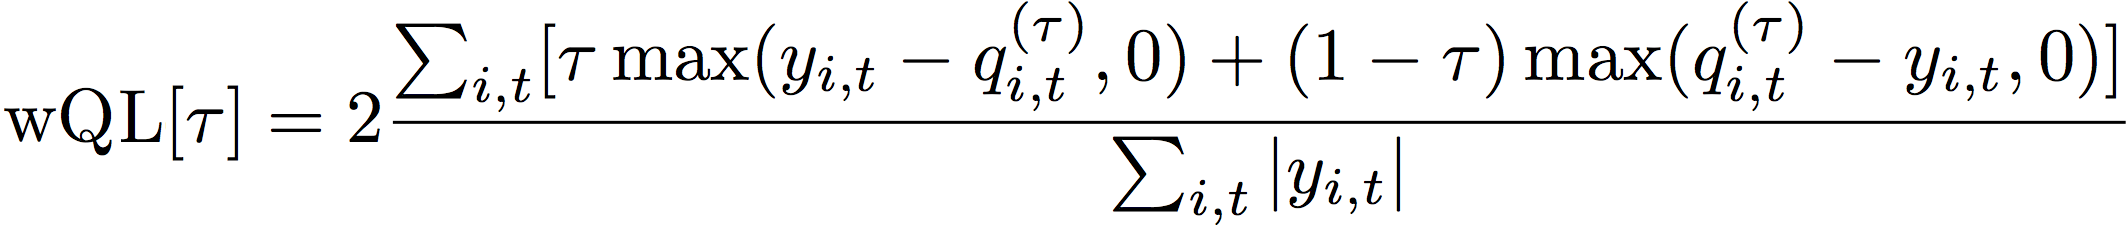

Where:
τ - a quantile in the set {0.01, 0.02, ..., 0.99}

qi,t(τ) - the τ-quantile that the model predicts.

yi,t - the observed value at point (i,t)


The quantiles (τ) for wQL can range from 0.01 (P1) to 0.99 (P99). The wQL metric cannot be calculated for the mean forecast.

By default, Forecast computes wQL at 0.1 (P10), 0.5 (P50), and 0.9 (P90).

- P10 (0.1) - The true value is expected to be lower than the predicted value 10% of the time.

- P50 (0.5) - The true value is expected to be lower than the predicted value 50% of the time. This is also known as the median forecast.

- P90 (0.9) - The true value is expected to be lower than the predicted value 90% of the time.

In retail, the cost of being understocked is often higher than the cost of being overstocked, and so forecasting at P75 (τ = 0.75) can be more informative than forecasting at the median quantile (P50). In these cases, wQL[0.75] assigns a larger penalty weight to underforecasting (0.75) and a smaller penalty weight to overforecasting (0.25).

Amazon Forecast also calculates the average wQL, which is the mean value of weighted quantile losses over all specified quantiles. By default, this will be the average of wQL[0.10], wQL[0.50], and wQL[0.90].

In [ ]:
def wQL(dataset, forecast, tau):
  array_max_yit_qit_0 = np.where((dataset["Volume"] -  dataset[forecast]) > 0, (dataset["Volume"] -  dataset[forecast]) , 0)
  array_max_qit_yit_0 = np.where(( dataset[forecast] - dataset["Volume"]) > 0, ( dataset[forecast] - dataset["Volume"]) , 0)
  return 200*( (sum(  tau * array_max_yit_qit_0 + (1-tau) * array_max_qit_yit_0  ))  /   (sum(  dataset["Volume"]  ))  )

In [ ]:
def meanWQL(dataset, forecast):
  return (wQL(dataset, forecast, 0.1) + wQL(dataset, forecast, 0.5) + wQL(dataset, forecast, 0.9))/3

In [ ]:
list_of_forecasts =  [
                     #  'APO_forecast', 'SalesHead_Corr_Forecast', 
                     'naive_predictions', 'perisitence_1', 'perisitence_3_mean',
                     'actuals_output', 'TFT_predictions', 'ARIMA', 'dual_TFT', 
                     'LSTM', 'multi_TFT_v3', 'TFT_encoded', 'TFT_predictions_v2'
                     ]

In [ ]:

ref_error = pd.DataFrame({
    "Method": list_of_forecasts,
    "MAE": [
            MAE(subset_of_main_data, list_of_forecasts[0]),
            MAE(subset_of_main_data, list_of_forecasts[1]),
            MAE(subset_of_main_data, list_of_forecasts[2]),
            MAE(subset_of_main_data, list_of_forecasts[3]),
            MAE(subset_of_main_data, list_of_forecasts[4]),
            MAE(subset_of_main_data, list_of_forecasts[5]),
            MAE(subset_of_main_data, list_of_forecasts[6]),
            MAE(subset_of_main_data, list_of_forecasts[7]),
            MAE(subset_of_main_data, list_of_forecasts[8]),
            MAE(subset_of_main_data, list_of_forecasts[9]),
            MAE(subset_of_main_data, list_of_forecasts[10])],
    "WMAPE":[
            WMAPE(subset_of_main_data, list_of_forecasts[0]),
            WMAPE(subset_of_main_data, list_of_forecasts[1]),
            WMAPE(subset_of_main_data, list_of_forecasts[2]),
            WMAPE(subset_of_main_data, list_of_forecasts[3]), 
            WMAPE(subset_of_main_data, list_of_forecasts[4]), 
            WMAPE(subset_of_main_data, list_of_forecasts[5]), 
            WMAPE(subset_of_main_data, list_of_forecasts[6]), 
            WMAPE(subset_of_main_data, list_of_forecasts[7]), 
            WMAPE(subset_of_main_data, list_of_forecasts[8]), 
            WMAPE(subset_of_main_data, list_of_forecasts[9]), 
            WMAPE(subset_of_main_data, list_of_forecasts[10])],
     "Aggregated WMAPE":[
            WMAPE(aggregate, list_of_forecasts[0]),
            WMAPE(aggregate, list_of_forecasts[1]),
            WMAPE(aggregate, list_of_forecasts[2]),
            WMAPE(aggregate, list_of_forecasts[3]), 
            WMAPE(aggregate, list_of_forecasts[4]), 
            WMAPE(aggregate, list_of_forecasts[5]), 
            WMAPE(aggregate, list_of_forecasts[6]), 
            WMAPE(aggregate, list_of_forecasts[7]), 
            WMAPE(aggregate, list_of_forecasts[8]), 
            WMAPE(aggregate, list_of_forecasts[9]), 
            WMAPE(aggregate, list_of_forecasts[10])],
    "wQL[0.1]":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.1),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.1),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.1),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.1)],
    "wQL[0.5] (WMAPE)":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.5),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.5),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.5),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.5)],
    "wQL[0.75]":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.75),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.75),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.75),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.75)],
    "wQL[0.9]":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.9),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.9),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.9),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.9)],
    "Mean wQL":[
            meanWQL(subset_of_main_data, list_of_forecasts[0]),
            meanWQL(subset_of_main_data, list_of_forecasts[1]),
            meanWQL(subset_of_main_data, list_of_forecasts[2]),
            meanWQL(subset_of_main_data, list_of_forecasts[3]), 
            meanWQL(subset_of_main_data, list_of_forecasts[4]), 
            meanWQL(subset_of_main_data, list_of_forecasts[5]), 
            meanWQL(subset_of_main_data, list_of_forecasts[6]), 
            meanWQL(subset_of_main_data, list_of_forecasts[7]), 
            meanWQL(subset_of_main_data, list_of_forecasts[8]), 
            meanWQL(subset_of_main_data, list_of_forecasts[9]), 
            meanWQL(subset_of_main_data, list_of_forecasts[10])]
            
            
                   }, 
    index=[i for i in range(len(list_of_forecasts))])

In [ ]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'white'), ('color', 'black')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #8900f2; color: white;'
}

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_compare(s, props=''):
    return np.where(s > s[0], props, '')

def highlight_compare2(s, props=''):
    return np.where(s < s[0], props, '')


s = ref_error.style
s = s.set_table_styles([cell_hover, index_names, headers])

# DataFrame maximum in red, and column maximums in orange.

s.apply(highlight_max, props='color:white;background-color:orange;', subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=0)\
  .apply(highlight_max, props='color:white;background-color:red', subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=None)\
  .apply(highlight_compare, props='color:#961c00;',subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=0)\
  .apply(highlight_compare2, props='color:green;',subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=0)\
  .set_properties(**{'background-color': '#8900f2', 'font-weight':'bold'}, subset=pd.IndexSlice[:, ['Method']])

print('DataFrame maximum in red, and column maximums in orange. If metric is larger than Naive i.e.[0] for that metric, text is dark red')
print('\033[93m Summary of errors:')
s

DataFrame maximum in red, and column maximums in orange. If metric is larger than Naive i.e.[0] for that metric, text is dark red
 Summary of errors:


,Method,MAE,WMAPE,Aggregated WMAPE,wQL[0.1],wQL[0.5] (WMAPE),wQL[0.75],wQL[0.9],Mean wQL
0,naive_predictions,40.568352,84.304947,62.370169,72.118935,84.304947,91.921204,96.490958,84.304947
1,perisitence_1,34.615874,71.935126,51.168809,72.828774,71.935126,71.376596,71.041477,71.935126
2,perisitence_3_mean,31.739148,65.957011,49.521603,60.205735,65.957011,69.551559,71.708287,65.957011
3,actuals_output,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TFT_predictions,33.828964,70.299852,52.658886,58.658150,70.299853,77.575918,81.941556,70.299853
5,ARIMA,38.716288,80.456181,60.125219,67.920708,80.456181,88.290852,92.991654,80.456181
6,dual_TFT,32.955994,68.485731,50.727862,53.658952,68.485731,77.752468,83.312510,68.485731
7,LSTM,79.530865,165.272810,131.944945,210.120375,165.272810,137.243082,120.425246,165.272810
8,multi_TFT_v3,33.468410,69.550592,51.732665,56.630357,69.550588,77.625732,82.470818,69.550588
9,TFT_encoded,35.110306,72.962606,57.054043,54.936580,72.962604,84.228869,90.988628,72.962604
